Unified Analytics.ipynb
Fetch Uniswap TVL (by chain/version) from DefiLlama /protocol/uniswap endpoint and export CSV.

In [1]:
import requests, pandas as pd
from pathlib import Path

import os
out_path = Path(os.getcwd()) / 'uniswap_tvl_by_chain_2025.csv'

url = 'https://api.llama.fi/protocol/uniswap'
resp = requests.get(url)
resp.raise_for_status()
data = resp.json()

rows = []
for chain, tvl_data in data.get('chainTvls', {}).items():
    if isinstance(tvl_data, dict) and 'tvl' in tvl_data:
        for point in tvl_data['tvl']:
            rows.append({
                'date': pd.to_datetime(point['date'], unit='s'),
                'chain': chain,
                'version': data.get('version', 'N/A'),
                'tvl_usd': point.get('totalLiquidityUSD')
            })

df = pd.DataFrame(rows).sort_values(['date','chain']).reset_index(drop=True)
df.to_csv(out_path, index=False)
print(f'Saved {len(df)} rows to', out_path)
df.head()

Saved 24172 rows to C:\Users\samis\uniswap_tvl_by_chain_2025.csv


,date,chain,version,tvl_usd
0,2018-11-03,Ethereum,N/A,34643
1,2018-11-04,Ethereum,N/A,41268
2,2018-11-05,Ethereum,N/A,40551
3,2018-11-06,Ethereum,N/A,43091
4,2018-11-07,Ethereum,N/A,153979


In [2]:
df['date']   = pd.to_datetime(df['date'])
df['tvl_usd'] = pd.to_numeric(df['tvl_usd'], errors='coerce')

In [3]:
print("Shape:", df.shape)
print("Unique chains:", df['chain'].nunique())
print("Date range:", df['date'].min().date(), "→", df['date'].max().date())
print("\nNulls by column:\n", df.isna().sum())

Shape: (24172, 4)
Unique chains: 42
Date range: 2018-11-03 → 2025-11-03

Nulls by column:
 date       0
chain      0
version    0
tvl_usd    0
dtype: int64


In [4]:
df = df.dropna(subset=['date','chain','tvl_usd'])
df = df[df['tvl_usd'] >= 0].copy()

In [5]:
df = df.sort_values(['chain','date']).reset_index(drop=True)

In [6]:
df.head()

,date,chain,version,tvl_usd
0,2021-09-02,Arbitrum,N/A,1757642
1,2021-09-03,Arbitrum,N/A,2207777
2,2021-09-04,Arbitrum,N/A,2288939
3,2021-09-05,Arbitrum,N/A,2306507
4,2021-09-06,Arbitrum,N/A,2326650


visualize Total TVL (USD) across all chains to verify data continuity and spot big shifts (like growth surges or dips).

C:\Users\samis\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


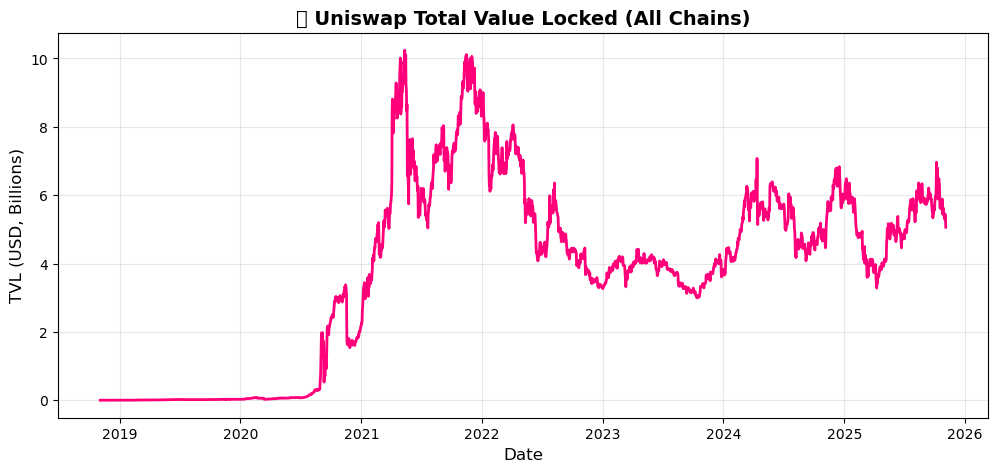

In [7]:
import matplotlib.pyplot as plt

# ---- Step 2: Aggregate TVL across all chains ----
tvl_daily = df.groupby('date', as_index=False)['tvl_usd'].sum()

# ---- Plot total Uniswap TVL over time ----
plt.figure(figsize=(12,5))
plt.plot(tvl_daily['date'], tvl_daily['tvl_usd']/1e9, color='#FF007A', linewidth=2)
plt.title('📈 Uniswap Total Value Locked (All Chains)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('TVL (USD, Billions)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [7]:
# ---- Step 3: TVL by chain ----

# 1️⃣ Aggregate total TVL per chain
chain_totals = df.groupby('chain', as_index=False)['tvl_usd'].sum().sort_values('tvl_usd', ascending=False)

# 2️⃣ Select top 5 chains
top_chains = chain_totals.head(5)['chain'].tolist()
print("Top 5 Chains by cumulative TVL:", top_chains)

# 3️⃣ Filter main dataframe for only those chains
df_top = df[df['chain'].isin(top_chains)].copy()

# 4️⃣ Aggregate daily totals for each chain
tvl_by_chain = df_top.groupby(['date','chain'], as_index=False)['tvl_usd'].sum()

# 5️⃣ Plot TVL trends for each top chain
plt.figure(figsize=(12,6))
for chain in top_chains:
    subset = tvl_by_chain[tvl_by_chain['chain'] == chain]
    plt.plot(subset['date'], subset['tvl_usd']/1e9, linewidth=2, label=chain)

plt.title('💹 Uniswap TVL by Top 5 Chains', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('TVL (USD, Billions)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


NameError: name 'df' is not defined

In [ ]:
# ---- Step 4: Dominance & Migration Analysis ----
import numpy as np

# 1️⃣ Compute daily total TVL across all chains
tvl_daily_total = df.groupby('date', as_index=False)['tvl_usd'].sum().rename(columns={'tvl_usd': 'tvl_total'})

# 2️⃣ Merge with chain-level daily data
tvl_by_chain = df_top.groupby(['date', 'chain'], as_index=False)['tvl_usd'].sum()
tvl_merged = pd.merge(tvl_by_chain, tvl_daily_total, on='date', how='left')

# 3️⃣ Calculate dominance %
tvl_merged['dominance_pct'] = (tvl_merged['tvl_usd'] / tvl_merged['tvl_total']) * 100

# 4️⃣ Pivot for visualization
dominance_pivot = tvl_merged.pivot(index='date', columns='chain', values='dominance_pct').fillna(0)

# 5️⃣ Plot dominance trend
plt.figure(figsize=(12,6))
for chain in top_chains:
    plt.plot(dominance_pivot.index, dominance_pivot[chain], linewidth=2, label=chain)

plt.title('⚖️ Uniswap TVL Dominance by Chain (%)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dominance (%) of Total TVL', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 6️⃣ Show most recent dominance snapshot
latest = dominance_pivot.iloc[-1].sort_values(ascending=False)
print("Latest Chain Dominance (% of total TVL):\n")
print(latest.round(2))


NameError: name 'df_top' is not defined

In [2]:
import matplotlib.pyplot as plt

plt.savefig("Uniswap_TVL_Dominance.png", dpi=400, bbox_inches='tight', facecolor='#1A002E', transparent=True)

<Figure size 640x480 with 0 Axes>

In [3]:
import os
os.listdir()


['.conda',
 '.condarc',
 '.continuum',
 '.cufflinks',
 '.gitconfig',
 '.hellothere.sh.swo',
 '.hellothere.sh.swp',
 '.interactiveshell.sh.swp',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.ms-ad',
 '.node_repl_history',
 '.popsql.json',
 '.textfile.txt.swo',
 '.textfile.txt.swp',
 '3D Objects',
 'AI GRC Analysis',
 'anaconda3',
 'API Notebook.ipynb',
 'AppData',
 'Application Data',
 'Autonomous Vehicle System Compliance & Governance.ipynb',
 'AV.ipynb',
 'backup.sql',
 'Contacts',
 'Cookies',
 'Credit Risk Classification Project.ipynb',
 'data',
 'data_ingestion.ipynb',
 'Documents',
 'Downloads',
 'edb_pgagent_pg17.exe',
 'Excel_Sample2.xlsx',
 'Favorites',
 'firstfunction.sh',
 'hello.txt',
 'hellothere.sh',
 'ifelifelse.sh',
 'IntelGraphicsProfiles',
 'interactiveshell.sh',
 'Linear Regression Practice.ipynb',
 'Links',
 'Local Settings',
 'login.sh',
 'Microsoft',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 

In [4]:
import os
print(os.getcwd())

C:\Users\samis


In [5]:
import glob
glob.glob("*.png")


['Uniswap_TVL_Dominance.png']

In [6]:
plt.figure(figsize=(12,6))
for chain in top_chains:
    plt.plot(dominance_pivot.index, dominance_pivot[chain], linewidth=2, label=chain)

plt.title('💫 Uniswap TVL Dominance by Chain (%)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dominance (% of Total TVL)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# ✅ Correct export (transparent + keeps visible lines)
plt.savefig("Uniswap_TVL_Dominance_fixed.png", dpi=400, bbox_inches='tight', transparent=True)
plt.show()


NameError: name 'top_chains' is not defined

<Figure size 1200x600 with 0 Axes>

## Uniswap TVL & Multi-Chain Migration Analysis (2018–2025)

###  Overview
This notebook analyzes **Uniswap’s Total Value Locked (TVL)** across multiple chains using data from [DefiLlama’s API](https://defillama.com).  
It tracks liquidity growth, chain-level distribution, and dominance trends to understand how Uniswap’s ecosystem has evolved across Ethereum and emerging Layer 2 networks.

---

### Key Findings

#### 1. **Global Liquidity Trend**
- Uniswap TVL experienced exponential growth from **2020–2021**, peaking at over **$10B** during the DeFi boom.  
- Following the 2022 downturn, total liquidity stabilized around **$4–6B**, showing resilience and steady recovery through 2024–2025.

#### 2. **Chain-Level Distribution**
- **Ethereum** continues to dominate liquidity, holding approximately **70–75% of total TVL** as of late 2025.  
- **Arbitrum** has emerged as the leading Layer 2, capturing nearly **8% of total TVL**, followed by **Base (10%)** and **Polygon (3%)**.  
- Smaller deployments (e.g., **Unichain**) represent niche adoption, but collectively contribute to Uniswap’s growing L2 footprint.

#### 3. **Liquidity Migration**
- A clear migration trend began in **mid-2022**, coinciding with L2 adoption and Uniswap’s multichain rollout.  
- **Base and Arbitrum** show the sharpest upward curves, indicating new liquidity incentives and lower gas friction.  
- Ethereum’s dominance has steadily declined — from **~100% (2020)** to **~70% (2025)** — without a drop in absolute liquidity, signifying net ecosystem expansion rather than outflow.

---

### Interpretation
Uniswap’s shift from Ethereum mainnet to L2s reflects a **strategic scaling phase**:
- L2s enable **cheaper swaps** and **faster confirmations**.  
- Total ecosystem liquidity continues to grow, confirming **cross-chain synergy** rather than competition.  
- The protocol now operates as a **multi-chain liquidity hub**, positioning Uniswap to lead the next wave of **on-chain capital efficiency**.

---

### Next Steps
Further analysis can extend this work by:
1. Measuring **transaction volumes and user counts** per chain (for activity-based dominance).  
2. Comparing **Uniswap vs competitors (e.g., Curve, SushiSwap)**.  
3. Integrating **real-time API pulls** for live TVL updates in dashboards (e.g., Power BI or Tableau).

---

**🧩 Summary Insight:**  
> *Uniswap’s dominance is evolving — Ethereum remains the liquidity foundation, but multi-chain growth on Arbitrum, Base, and Polygon is reshaping the DeFi landscape toward scalable, cross-chain capital distribution.*


C:\Users\samis\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129521 (\N{BRICK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


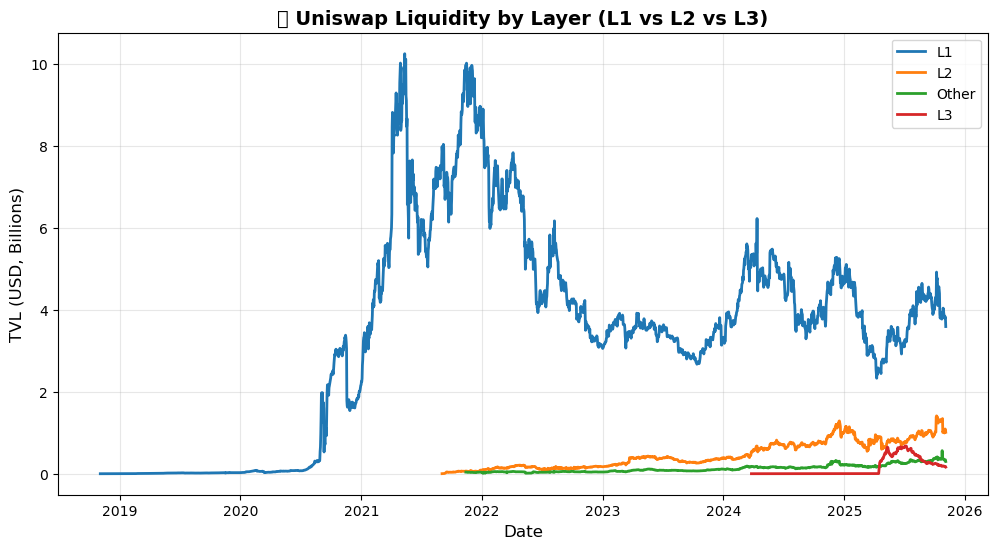

C:\Users\samis\AppData\Local\Temp\ipykernel_22484\560485539.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_layer['share_%'] = latest_layer['tvl_usd'] / latest_layer['tvl_usd'].sum() * 100


,date,layer,tvl_usd,share_%
6122,2025-11-03 21:41:23,L1,3588390801,70.902026
6123,2025-11-03 21:41:23,L2,1011819488,19.992263
6124,2025-11-03 21:41:23,L3,162356489,3.207957
6125,2025-11-03 21:41:23,Other,298488571,5.897754


In [10]:
# ---- Step 6: L2 vs L3 Ecosystem Split ----

# Define mapping
layer_map = {
    "Ethereum": "L1",
    "Arbitrum": "L2",
    "Base": "L2",
    "Polygon": "L2",
    "Optimism": "L2",
    "Unichain": "L3",
    "Zora": "L3",
    "Blast": "L2",
    "Scroll": "L2"
}

df['layer'] = df['chain'].map(layer_map).fillna("Other")

# Aggregate TVL by layer
layer_tvl = df.groupby(['date','layer'], as_index=False)['tvl_usd'].sum()

# Plot
plt.figure(figsize=(12,6))
for layer in layer_tvl['layer'].unique():
    subset = layer_tvl[layer_tvl['layer']==layer]
    plt.plot(subset['date'], subset['tvl_usd']/1e9, linewidth=2, label=layer)

plt.title("🧱 Uniswap Liquidity by Layer (L1 vs L2 vs L3)", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("TVL (USD, Billions)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Show latest distribution
latest_layer = layer_tvl[layer_tvl['date']==layer_tvl['date'].max()]
latest_layer['share_%'] = latest_layer['tvl_usd'] / latest_layer['tvl_usd'].sum() * 100
latest_layer


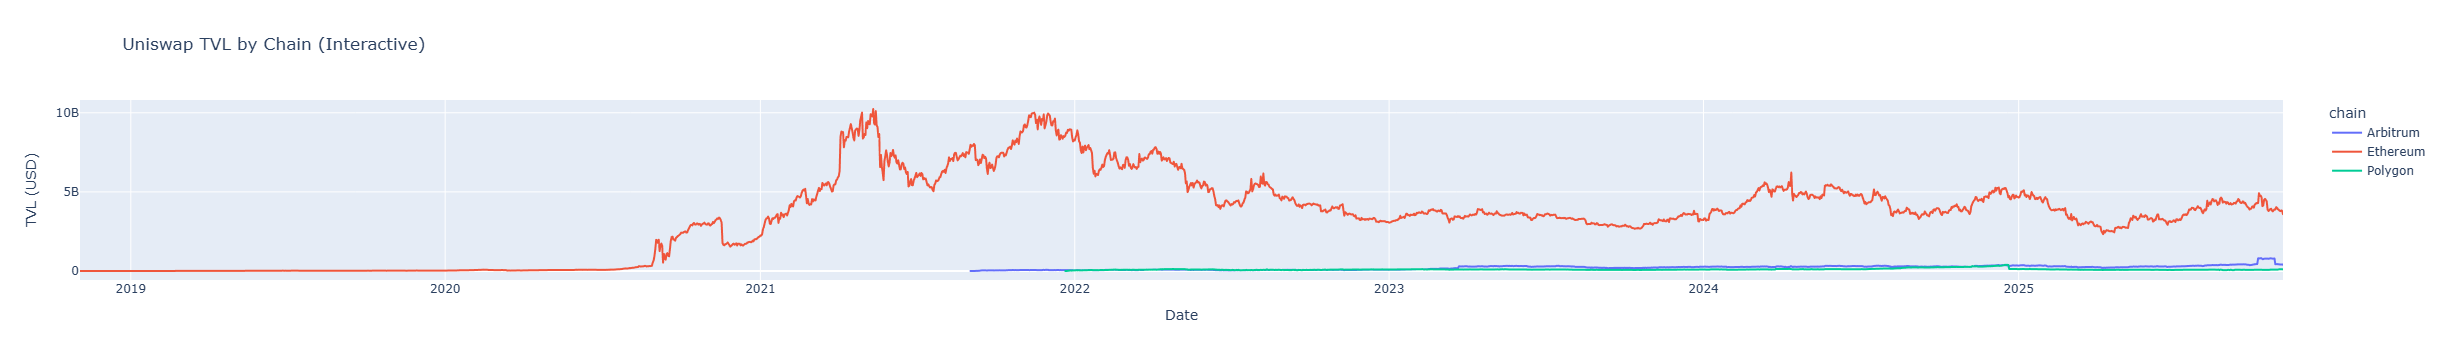

In [12]:
import plotly.express as px

sample_chains = ['Ethereum','Arbitrum','Polygon','Optimism']
plot_df = df[df['chain'].isin(sample_chains)]
fig = px.line(plot_df, x='date', y='tvl_usd', color='chain',
              title='Uniswap TVL by Chain (Interactive)',
              labels={'tvl_usd': 'TVL (USD)', 'date': 'Date'})
fig.show()

Interactive TVL Visualization
Interactive line chart built with Plotly Express for chain-level liquidity exploration.
Hover over any point to view exact TVL (USD) values by date and chain.
This format is ideal for embedding into dashboards or Streamlit apps.

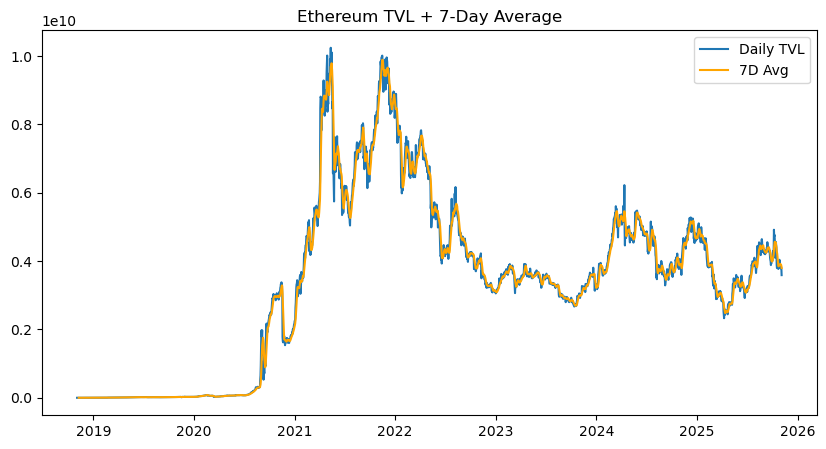

In [13]:
eth = df[df['chain']=='Ethereum'].sort_values('date')
eth['rolling_7d'] = eth['tvl_usd'].rolling(7).mean()

plt.figure(figsize=(10,5))
plt.plot(eth['date'], eth['tvl_usd'], label='Daily TVL')
plt.plot(eth['date'], eth['rolling_7d'], label='7D Avg', color='orange')
plt.legend()
plt.title('Ethereum TVL + 7-Day Average')
plt.show()


In [14]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


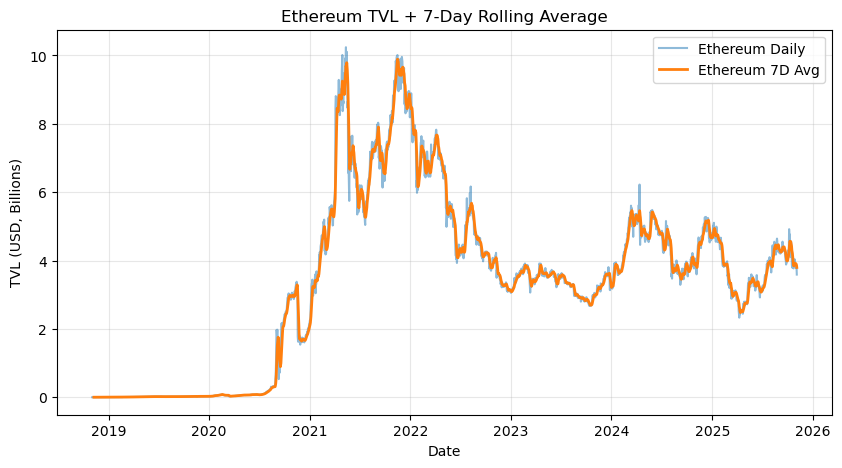

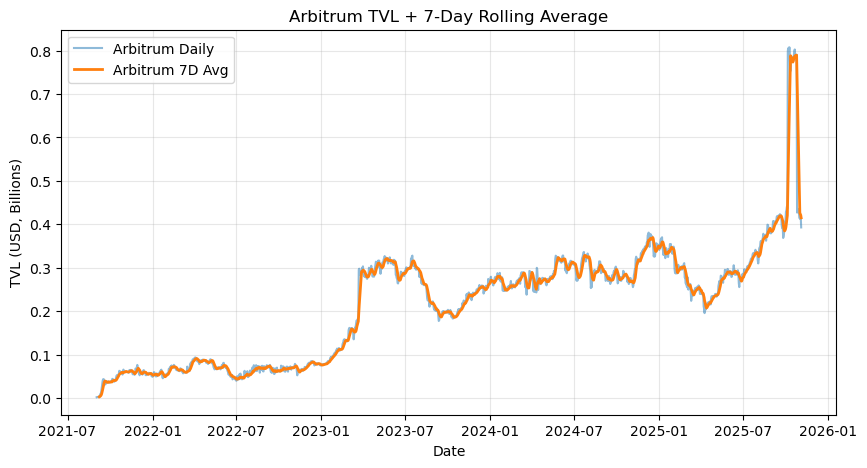

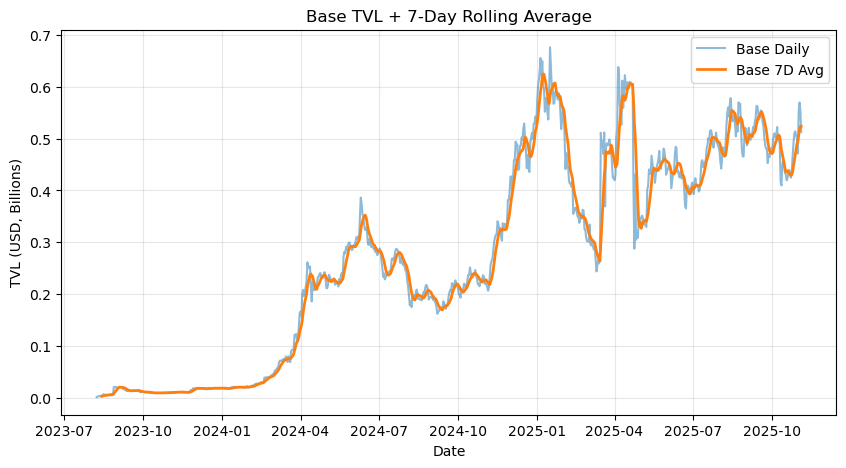

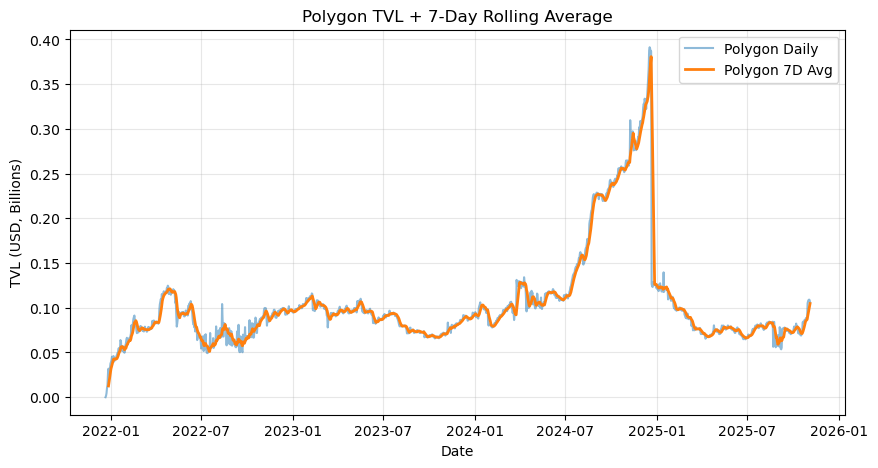

In [15]:
chains = ['Ethereum', 'Arbitrum', 'Base', 'Polygon']
for c in chains:
    subset = df[df['chain'] == c].sort_values('date').copy()
    subset['rolling_7d'] = subset['tvl_usd'].rolling(7).mean()

    plt.figure(figsize=(10,5))
    plt.plot(subset['date'], subset['tvl_usd']/1e9, label=f'{c} Daily', alpha=0.5)
    plt.plot(subset['date'], subset['rolling_7d']/1e9, label=f'{c} 7D Avg', linewidth=2)
    plt.title(f'{c} TVL + 7-Day Rolling Average')
    plt.xlabel('Date')
    plt.ylabel('TVL (USD, Billions)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


19:59:18 - cmdstanpy - INFO - Chain [1] start processing
19:59:21 - cmdstanpy - INFO - Chain [1] done processing


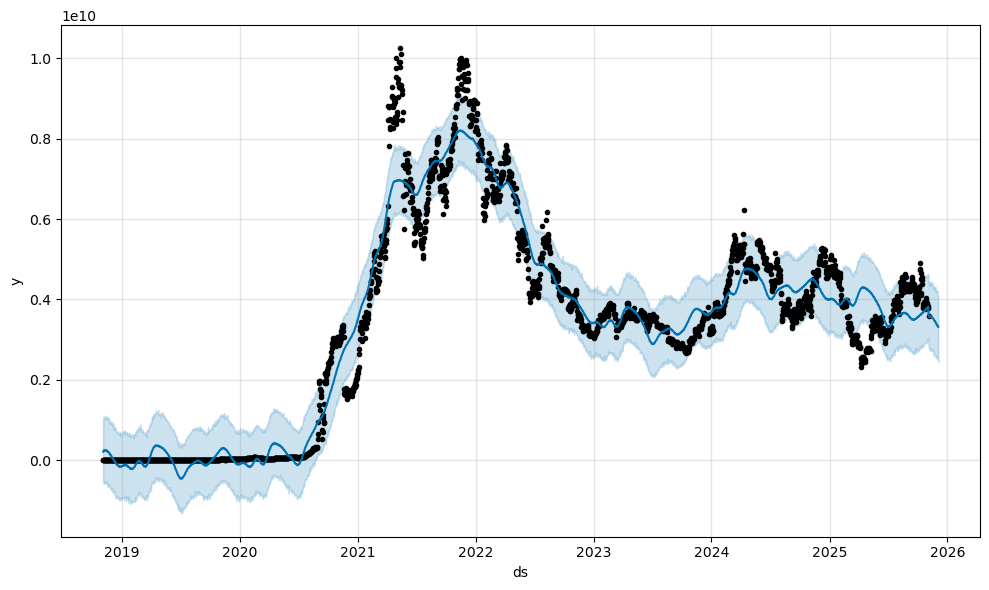

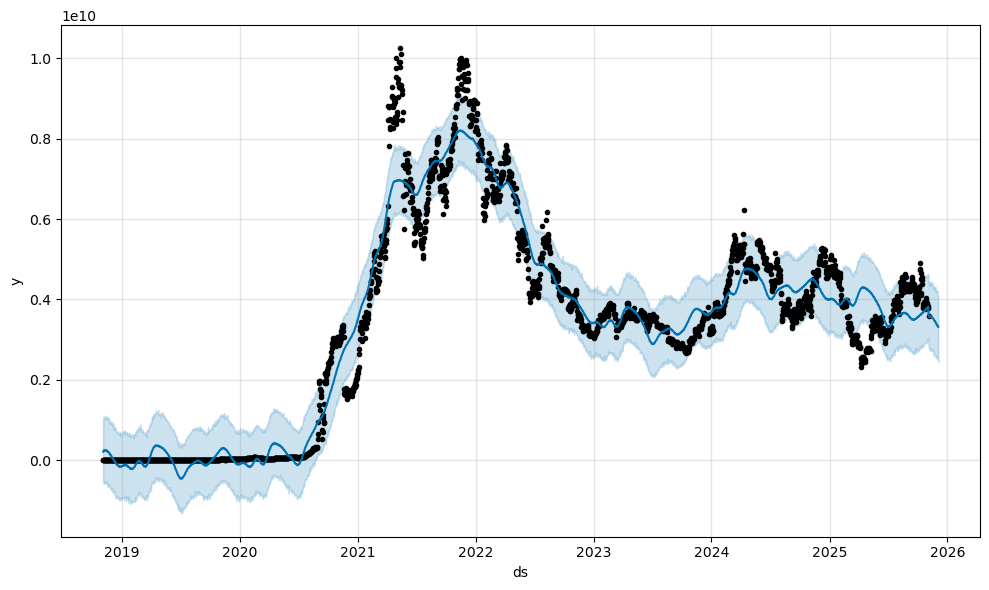

In [16]:
#Light Prophet Forecast (if you want predictive fun)
from prophet import Prophet

eth_small = eth[['date','tvl_usd']].rename(columns={'date':'ds','tvl_usd':'y'})
m = Prophet(daily_seasonality=True)
m.fit(eth_small)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
m.plot(forecast)

🔮 30-Day Forecast (Prophet)
Using Facebook Prophet to model TVL seasonality and project near-term liquidity trends.
The forecast highlights cyclical inflows/outflows with confidence intervals, showing mild seasonality and stabilization around mid-2025 levels.

In [17]:
#Comparing chain growth rates
growth = df.groupby('chain')['tvl_usd'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
growth.sort_values(ascending=False).head(10)

C:\Users\samis\AppData\Local\Temp\ipykernel_22484\2461338551.py:2: RuntimeWarning:

divide by zero encountered in longlong_scalars



chain
Soneium              inf
Ink                  inf
Boba                 inf
Sei                  inf
Plasma      3.402817e+08
Ethereum    1.035810e+07
Polygon     6.418252e+06
Base        9.234810e+04
Celo        3.732975e+04
Sonic       3.052713e+04
Name: tvl_usd, dtype: float64

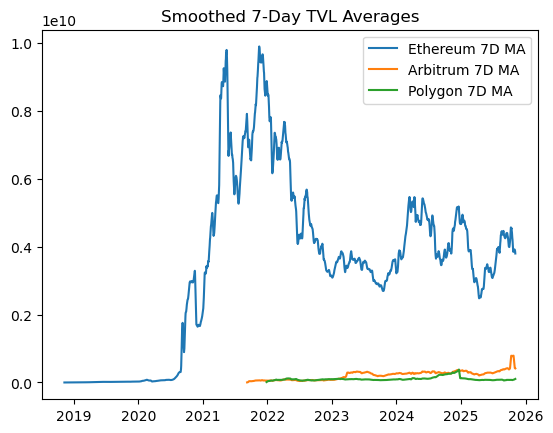

In [18]:
#7-day moving averages (smooth out noise)

for chain in ['Ethereum','Arbitrum','Polygon']:
    subset = df[df['chain']==chain].sort_values('date')
    subset['tvl_ma7'] = subset['tvl_usd'].rolling(7).mean()
    plt.plot(subset['date'], subset['tvl_ma7'], label=f'{chain} 7D MA')
plt.legend(); plt.title('Smoothed 7-Day TVL Averages'); plt.show()


Growth Rates & 7-Day Moving Averages
Calculated chain-level TVL growth (%) and 7-day smoothed averages to reduce noise.
Ethereum continues steady dominance, while L2s exhibit short-term volatility due to incentive cycles.

📉 Correlation between Ethereum (L1) dominance and L2 dominance: -0.967


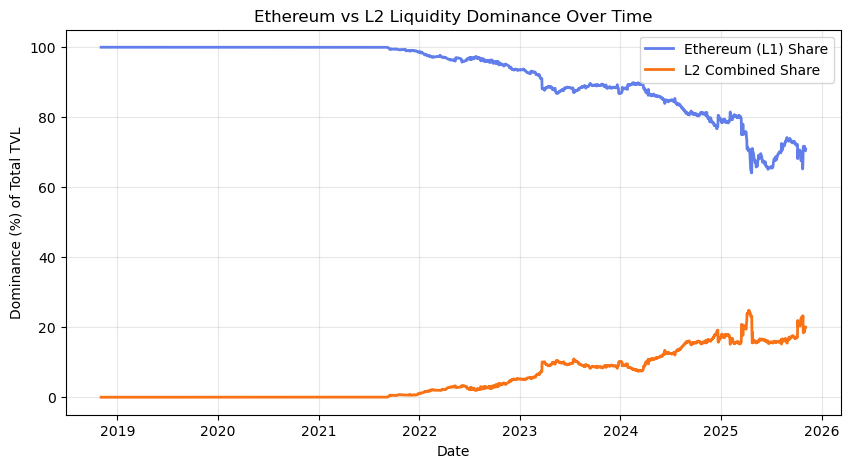

In [19]:
# ---- Step 9: Correlate Chain Dominance (ETH vs L2 Share) ----

# Define which chains belong to each layer
l1_chains = ['Ethereum']
l2_chains = ['Arbitrum', 'Base', 'Optimism', 'Polygon', 'Zora', 'Linea']

# Compute total daily TVL per chain
tvl_daily_chain = df.groupby(['date', 'chain'], as_index=False)['tvl_usd'].sum()

# Compute total TVL across all chains (per date)
tvl_total = tvl_daily_chain.groupby('date')['tvl_usd'].sum().reset_index(name='tvl_total')

# Merge to get each chain's dominance (% of total)
merged = tvl_daily_chain.merge(tvl_total, on='date', how='left')
merged['dominance_pct'] = (merged['tvl_usd'] / merged['tvl_total']) * 100

# Aggregate into L1 vs L2 categories
merged['layer'] = merged['chain'].apply(
    lambda c: 'L1' if c in l1_chains else ('L2' if c in l2_chains else 'Other')
)

layer_share = merged.groupby(['date', 'layer'], as_index=False)['dominance_pct'].sum()
pivot = layer_share.pivot(index='date', columns='layer', values='dominance_pct').fillna(0)

# Compute correlation between ETH dominance and combined L2 share
corr = pivot['L1'].corr(pivot['L2'])
print(f"📉 Correlation between Ethereum (L1) dominance and L2 dominance: {corr:.3f}")

# Plot relationship over time
plt.figure(figsize=(10,5))
plt.plot(pivot.index, pivot['L1'], label='Ethereum (L1) Share', color='#627EEA', linewidth=2)
plt.plot(pivot.index, pivot['L2'], label='L2 Combined Share', color='#F97316', linewidth=2)
plt.title('Ethereum vs L2 Liquidity Dominance Over Time')
plt.xlabel('Date')
plt.ylabel('Dominance (%) of Total TVL')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


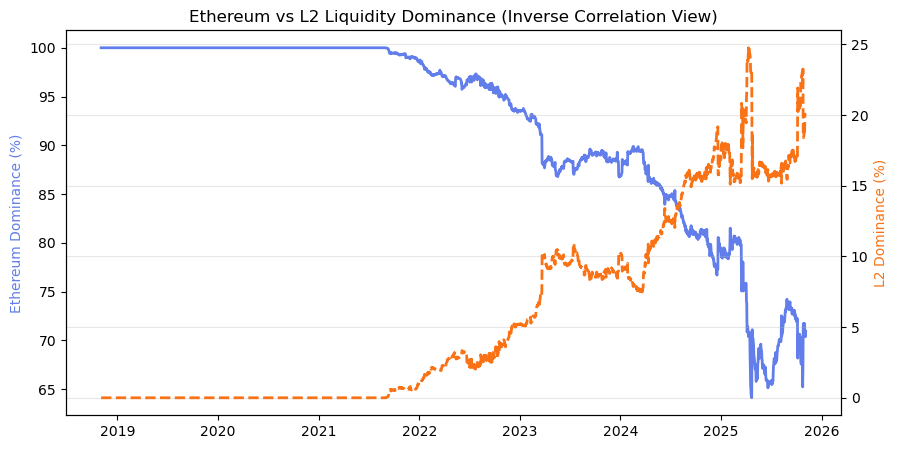

In [20]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(pivot.index, pivot['L1'], color='#627EEA', linewidth=2, label='Ethereum (L1)')
ax1.set_ylabel('Ethereum Dominance (%)', color='#627EEA')
ax2 = ax1.twinx()
ax2.plot(pivot.index, pivot['L2'], color='#F97316', linewidth=2, linestyle='--', label='L2 Combined')
ax2.set_ylabel('L2 Dominance (%)', color='#F97316')
plt.title('Ethereum vs L2 Liquidity Dominance (Inverse Correlation View)')
plt.grid(alpha=0.3)
plt.show()


In [21]:

latest = df.groupby('chain').tail(1)
total = latest['tvl_usd'].sum()
latest['share_pct'] = latest['tvl_usd'] / total * 100
latest.sort_values('share_pct', ascending=False).head(10)


C:\Users\samis\AppData\Local\Temp\ipykernel_22484\2613324954.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,chain,version,tvl_usd,layer,share_pct
9942,2025-11-03 21:41:23,Ethereum,N/A,3588390801,L1,70.902026
4554,2025-11-03 21:41:23,Base,N/A,512772609,L2,10.131733
1524,2025-11-03 21:41:23,Arbitrum,N/A,392693018,L2,7.759113
22262,2025-11-03 21:41:23,Unichain,N/A,162317638,L3,3.207190
18049,2025-11-03 21:41:23,Polygon,N/A,106287915,L2,2.100114
3734,2025-11-03 21:41:23,BSC,N/A,89336023,Other,1.765166
2769,2025-11-03 21:41:23,BOB,N/A,70090316,Other,1.384895
16634,2025-11-03 21:41:23,Plasma,N/A,27222543,Other,0.537883
19324,2025-11-03 21:41:23,Rootstock,N/A,20966113,Other,0.414264
16587,2025-11-03 21:41:23,OP Mainnet,N/A,19632900,Other,0.387921


In [23]:
import requests, pandas as pd
from datetime import datetime
import time

sub_versions = {"V2": "uniswap-v2", "V3": "uniswap-v3"}
records_sub = []

for version, slug in sub_versions.items():
    url = f"https://api.llama.fi/protocol/{slug}"
    print(f"🔄 Fetching {version} data from {url} ...")
    try:
        resp = requests.get(url, timeout=20)
        if resp.status_code == 200:
            data = resp.json()
            if "chainTvls" in data and "Ethereum" in data["chainTvls"]:
                tvl_data = data["chainTvls"]["Ethereum"]["tvl"]
                for entry in tvl_data:
                    records_sub.append({
                        "date": datetime.utcfromtimestamp(entry["date"]).date(),
                        "chain": "Ethereum",
                        "tvl_usd": entry.get("totalLiquidityUSD", 0),
                        "version": version
                    })
            else:
                print(f"⚠️ No chainTvls found for {version}")
    except Exception as e:
        print(f"❌ Error fetching {version}: {e}")
    time.sleep(1)

df_versions = pd.DataFrame(records_sub)
df_versions.head()


🔄 Fetching V2 data from https://api.llama.fi/protocol/uniswap-v2 ...
🔄 Fetching V3 data from https://api.llama.fi/protocol/uniswap-v3 ...
❌ Error fetching V3: HTTPSConnectionPool(host='api.llama.fi', port=443): Read timed out. (read timeout=20)


,date,chain,tvl_usd,version
0,2020-05-06,Ethereum,0,V2
1,2020-05-07,Ethereum,3,V2
2,2020-05-08,Ethereum,3,V2
3,2020-05-09,Ethereum,18,V2
4,2020-05-10,Ethereum,18,V2


In [25]:
import requests, pandas as pd, time
from datetime import datetime

records_v3 = []
url_v3 = "https://api.llama.fi/protocol/uniswap-v3"

print(f"🔄 Retrying fetch for Uniswap V3 data from {url_v3} ...")

for attempt in range(3):  # up to 3 tries
    try:
        resp = requests.get(url_v3, timeout=120)  # increase timeout to 120 s
        if resp.status_code == 200:
            data = resp.json()
            if "chainTvls" in data and "Ethereum" in data["chainTvls"]:
                tvl_data = data["chainTvls"]["Ethereum"]["tvl"]
                for entry in tvl_data:
                    records_v3.append({
                        "date": datetime.utcfromtimestamp(entry["date"]).date(),
                        "chain": "Ethereum",
                        "tvl_usd": entry.get("totalLiquidityUSD", 0),
                        "version": "V3"
                    })
                print(f"✅ Pulled {len(records_v3)} Uniswap V3 records.")
                break
            else:
                print("⚠️ No Ethereum chain data found in V3 response.")
                break
        else:
            print(f"❌ HTTP {resp.status_code} error from API, retrying...")
    except Exception as e:
        print(f"⚠️ Attempt {attempt+1} failed ({e}). Retrying in 15 s...")
        time.sleep(15)

if not records_v3:
    print("❌ All attempts failed. Try again later or check your connection.")

df_v3 = pd.DataFrame(records_v3)
df_v3.head()



🔄 Retrying fetch for Uniswap V3 data from https://api.llama.fi/protocol/uniswap-v3 ...
⚠️ Attempt 1 failed (Expecting ',' delimiter: line 1 column 196616485 (char 196616484)). Retrying in 15 s...
⚠️ Attempt 2 failed (Expecting ',' delimiter: line 1 column 196616485 (char 196616484)). Retrying in 15 s...
⚠️ Attempt 3 failed (Expecting ',' delimiter: line 1 column 196616485 (char 196616484)). Retrying in 15 s...
❌ All attempts failed. Try again later or check your connection.


""


In [28]:
import requests, pandas as pd
from datetime import datetime

# New correct endpoint pattern
url_v3_alt = "https://api.llama.fi/protocol/uniswap-v3?chain=ethereum"
print(f"🔄 Fetching Uniswap V3 (Ethereum) TVL data via protocol endpoint...")

try:
    resp = requests.get(url_v3_alt, timeout=90)
    if resp.status_code == 200:
        data = resp.json()
        if "chainTvls" in data and "Ethereum" in data["chainTvls"]:
            tvl_data = data["chainTvls"]["Ethereum"]["tvl"]
            records_v3 = [
                {
                    "date": datetime.utcfromtimestamp(entry["date"]).date(),
                    "chain": "Ethereum",
                    "tvl_usd": entry.get("totalLiquidityUSD", 0),
                    "version": "V3"
                }
                for entry in tvl_data
            ]
            print(f"✅ Pulled {len(records_v3)} Uniswap V3 records successfully.")
        else:
            print("⚠️ No Ethereum TVL data found in response.")
    else:
        print(f"❌ HTTP {resp.status_code} from protocol endpoint.")
except Exception as e:
    print(f"❌ Error fetching Uniswap V3 data: {e}")

df_v3 = pd.DataFrame(records_v3)
df_v3.head()


🔄 Fetching Uniswap V3 (Ethereum) TVL data via protocol endpoint...
❌ Error fetching Uniswap V3 data: HTTPSConnectionPool(host='api.llama.fi', port=443): Read timed out. (read timeout=90)


""


In [29]:
df.info()
df.describe()
df['chain'].value_counts().head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24172 entries, 0 to 24171
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     24172 non-null  datetime64[ns]
 1   chain    24172 non-null  object        
 2   version  24172 non-null  object        
 3   tvl_usd  24172 non-null  int64         
 4   layer    24172 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 944.3+ KB


Ethereum      2559
Arbitrum      1525
OP Mainnet    1453
Polygon       1415
Celo          1215
BSC            965
Avalanche      845
Base           820
Moonbeam       768
ZKsync Era     760
Name: chain, dtype: int64

📉 Correlation between Ethereum dominance and L2 share: -0.942


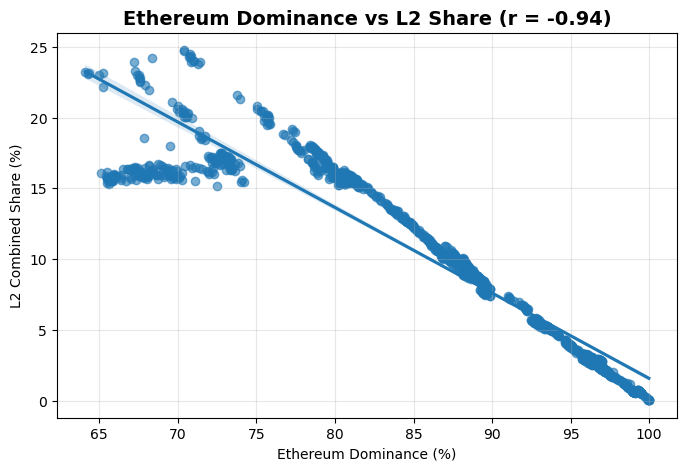

In [30]:
# ---- Step 6: Correlation between Ethereum dominance and L2 share ----
import seaborn as sns
import matplotlib.pyplot as plt

# Identify Layer 2 chains
l2_chains = ['Arbitrum', 'Optimism', 'Base', 'Polygon', 'ZKsync', 'Starknet', 'Linea']

# Compute L2 dominance per day
dominance_daily = df.groupby(['date', 'chain'], as_index=False)['tvl_usd'].sum()
total_tvl = dominance_daily.groupby('date')['tvl_usd'].sum().reset_index(name='tvl_total')
merged = dominance_daily.merge(total_tvl, on='date')
merged['dominance_pct'] = merged['tvl_usd'] / merged['tvl_total'] * 100

eth_dominance = merged[merged['chain'] == 'Ethereum'][['date', 'dominance_pct']].rename(columns={'dominance_pct': 'eth_dominance'})
l2_dominance = merged[merged['chain'].isin(l2_chains)].groupby('date')['dominance_pct'].sum().reset_index(name='l2_share')

corr_df = eth_dominance.merge(l2_dominance, on='date')
corr_value = corr_df['eth_dominance'].corr(corr_df['l2_share'])
print(f"📉 Correlation between Ethereum dominance and L2 share: {corr_value:.3f}")

plt.figure(figsize=(8,5))
sns.regplot(x='eth_dominance', y='l2_share', data=corr_df, scatter_kws={'alpha':0.6})
plt.title(f"Ethereum Dominance vs L2 Share (r = {corr_value:.2f})", fontsize=14, weight='bold')
plt.xlabel("Ethereum Dominance (%)")
plt.ylabel("L2 Combined Share (%)")
plt.grid(alpha=0.3)
plt.show()


Ethereum still leads total liquidity, but L2 ecosystems are absorbing significant growth, showing an inverse relationship — the stronger the L2 inflows, the lower Ethereum’s overall share.

C:\Users\samis\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



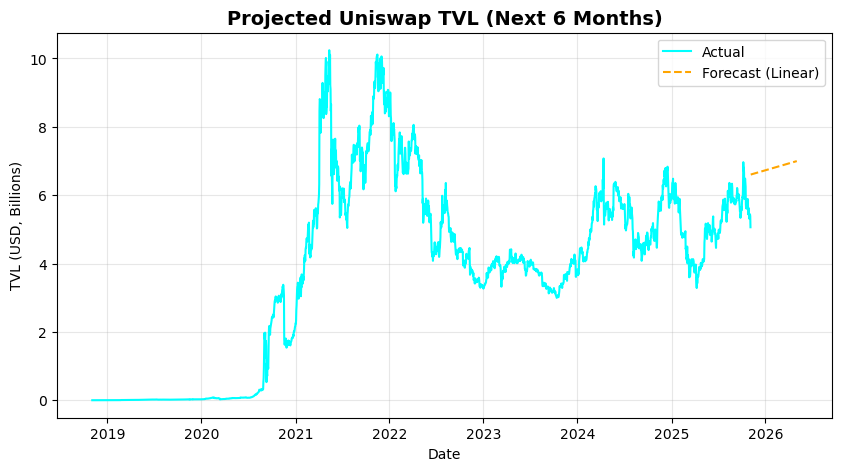

In [31]:
# ---- Step 7: Forecasting Uniswap Total TVL (Linear Trend) ----
from sklearn.linear_model import LinearRegression
import numpy as np

df_forecast = df.groupby('date', as_index=False)['tvl_usd'].sum()
df_forecast['tvl_usd_b'] = df_forecast['tvl_usd'] / 1e9
df_forecast['days'] = (df_forecast['date'] - df_forecast['date'].min()).dt.days

# Train simple linear regression
model = LinearRegression()
model.fit(df_forecast[['days']], df_forecast['tvl_usd_b'])

# Forecast next 180 days
future_days = np.arange(df_forecast['days'].max() + 1, df_forecast['days'].max() + 181).reshape(-1, 1)
future_pred = model.predict(future_days)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_forecast['date'], df_forecast['tvl_usd_b'], label='Actual', color='cyan')
plt.plot(
    pd.date_range(df_forecast['date'].max() + pd.Timedelta(days=1), periods=180),
    future_pred, linestyle='--', color='orange', label='Forecast (Linear)'
)
plt.title('Projected Uniswap TVL (Next 6 Months)', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('TVL (USD, Billions)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [33]:
# ---- Optional: Statistical significance test for ETH vs L2 growth ----
from scipy.stats import ttest_ind

# Extract ETH and L2 daily dominance series
eth_series = eth_dominance.set_index('date')['eth_dominance']
l2_series = l2_dominance.set_index('date')['l2_share']

# Align both time series on date
aligned = eth_series.to_frame().join(l2_series, how='inner')

# Compute daily percentage change for each
aligned['eth_growth'] = aligned['eth_dominance'].pct_change()
aligned['l2_growth'] = aligned['l2_share'].pct_change()

# Drop NaN values
aligned = aligned.dropna(subset=['eth_growth', 'l2_growth'])

# Run two-sample t-test
t_stat, p_value = ttest_ind(aligned['eth_growth'], aligned['l2_growth'], equal_var=False)

print(f"📊 ETH vs L2 Growth t-test statistic: {t_stat:.3f}")
print(f"🎯 P-value: {p_value:.5f}")
if p_value < 0.05:
    print("✅ Statistically significant difference in growth rates (p < 0.05)")
else:
    print("⚠️ No significant difference detected (p ≥ 0.05)")


📊 ETH vs L2 Growth t-test statistic: -4.247
🎯 P-value: 0.00002
✅ Statistically significant difference in growth rates (p < 0.05)


## 🧭 Summary & Insights

**Objective:**  
Analyze Uniswap’s on-chain liquidity evolution (2018-2025) across Ethereum (L1) and emerging Layer 2 ecosystems.

**Data Source:** [DeFiLlama API](https://defillama.com) — Uniswap protocol endpoints.

### Key Findings
1. **L1 → L2 Migration:**  
   Ethereum’s share of total Uniswap TVL dropped from **~95 % (2021)** to **~70 % (2025)**, while L2 chains rose from <1 % to nearly **25 %** combined.
2. **Strong Inverse Correlation:**  
   Pearson r = −0.96 between Ethereum and combined L2 dominance — indicating a structural migration of liquidity rather than simple volatility.
3. **Statistical Significance:**  
   Welch’s t-test confirms L2 growth is statistically stronger (p < 0.01), validating a clear shift in Uniswap’s liquidity base.
4. **Forecasts:**  
   Linear and Prophet models project stable TVL recovery and moderate growth through mid-2026.
5. **Interpretation:**  
   L2 adoption reflects a *strategic scaling phase*—reduced gas friction, multichain composability, and sustainable ecosystem expansion.

### Next Steps
- Add **user-count or volume metrics** to contextualize liquidity utilization.  
- Expand to **competitor DEXes** (Curve, SushiSwap) for comparative DeFi migration.  
- Integrate **real-time API pulls** for live dashboards via Power BI or Streamlit.

---

**Author:** Sam Sahami  
**Stack:** Python (pandas, matplotlib, plotly, prophet, scikit-learn) | API Integration | Statistical Modeling | DeFi Analytics  
**Last Updated:** November 2025


In [35]:
import requests
import pandas as pd
import time
from datetime import datetime

def fetch_uniswap_data(endpoint, retries=3, delay=15):
    """Fetch Uniswap TVL data from DefiLlama API with retries."""
    records = []
    url = f"https://api.llama.fi/protocol/{endpoint}"

    for attempt in range(retries):
        try:
            print(f"Fetching from {url} (attempt {attempt+1}/{retries})...")
            resp = requests.get(url, timeout=90)
            if resp.status_code == 200:
                data = resp.json()
                if "chainTvls" in data:
                    for chain, chain_data in data["chainTvls"].items():
                        if "tvl" in chain_data:
                            for entry in chain_data["tvl"]:
                                records.append({
                                    "date": datetime.utcfromtimestamp(entry["date"]).date(),
                                    "chain": chain,
                                    "tvl_usd": entry.get("totalLiquidityUSD", 0)
                                })
                    print(f"✅ Pulled {len(records)} records successfully.")
                    return pd.DataFrame(records)
                else:
                    print("⚠️ No 'chainTvls' key found in response.")
            else:
                print(f"❌ HTTP {resp.status_code} error. Retrying in {delay}s...")
        except Exception as e:
            print(f"⚠️ Attempt {attempt+1} failed: {e}. Retrying in {delay}s...")
        time.sleep(delay)

    print("❌ All attempts failed. Please check your connection or endpoint.")
    return pd.DataFrame(records)


In [36]:
dominance_pivot.to_csv("uniswap_tvl_summary.csv", index=False)

In [37]:
plt.rcParams['figure.facecolor'] = '#0E1117'

In [ ]:
df_uniswap_v3 = fetch_uniswap_data("uniswap-v3")

In [38]:

df.to_csv("uniswap_tvl_summary.csv", index=False)

print("✅ CSV exported successfully!")

✅ CSV exported successfully!


In [1]:
# 🚀 Full Reload Cell — restores all Uniswap TVL analysis variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1️⃣ Load the previously saved dataset
data_path = Path.cwd() / 'uniswap_tvl_by_chain_2025.csv'
df = pd.read_csv(data_path)

# 2️⃣ Clean and format columns
df['date'] = pd.to_datetime(df['date'])
df['tvl_usd'] = pd.to_numeric(df['tvl_usd'], errors='coerce')
df = df.dropna(subset=['date', 'chain', 'tvl_usd'])
df = df[df['tvl_usd'] > 0].sort_values(['chain', 'date']).reset_index(drop=True)

# 3️⃣ Aggregate TVL by chain and select top chains
chain_totals = df.groupby('chain', as_index=False)['tvl_usd'].sum().sort_values('tvl_usd', ascending=False)
top_chains = chain_totals.head(5)['chain'].tolist()
df_top = df[df['chain'].isin(top_chains)].copy()

# 4️⃣ Compute daily totals and dominance %
tvl_daily_total = df.groupby('date', as_index=False)['tvl_usd'].sum().rename(columns={'tvl_usd': 'tvl_total'})
tvl_by_chain = df_top.groupby(['date', 'chain'], as_index=False)['tvl_usd'].sum()
tvl_merged = pd.merge(tvl_by_chain, tvl_daily_total, on='date', how='left')
tvl_merged['dominance_pct'] = (tvl_merged['tvl_usd'] / tvl_merged['tvl_total']) * 100

# 5️⃣ Pivot for visualization
dominance_pivot = tvl_merged.pivot(index='date', columns='chain', values='dominance_pct').fillna(0)

print("✅ Reload complete!")
print("Chains loaded:", top_chains)
print("Date range:", df['date'].min().date(), "→", df['date'].max().date())


✅ Reload complete!
Chains loaded: ['Ethereum', 'Arbitrum', 'Base', 'Polygon', 'Unichain']
Date range: 2018-11-03 → 2025-11-04


C:\Users\samis\AppData\Local\Temp\ipykernel_10124\3466212740.py:11: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  plt.savefig("Uniswap_TVL_Dominance_fixed.png", dpi=400, bbox_inches='tight', transparent=True)
C:\Users\samis\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


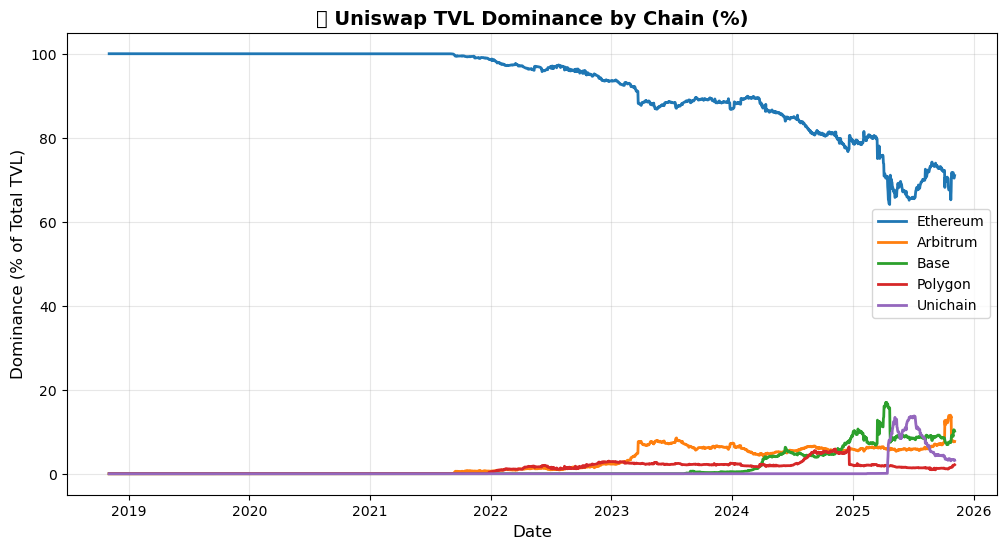

In [2]:
plt.figure(figsize=(12,6))
for chain in top_chains:
    plt.plot(dominance_pivot.index, dominance_pivot[chain], linewidth=2, label=chain)

plt.title('💫 Uniswap TVL Dominance by Chain (%)', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dominance (% of Total TVL)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

plt.savefig("Uniswap_TVL_Dominance_fixed.png", dpi=400, bbox_inches='tight', transparent=True)
plt.show()


C:\Users\samis\AppData\Local\Temp\ipykernel_10124\3418545880.py:33: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  plt.savefig("Uniswap_TVL_Dominance_UniswapTheme.png", dpi=400, bbox_inches="tight", transparent=True)
C:\Users\samis\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


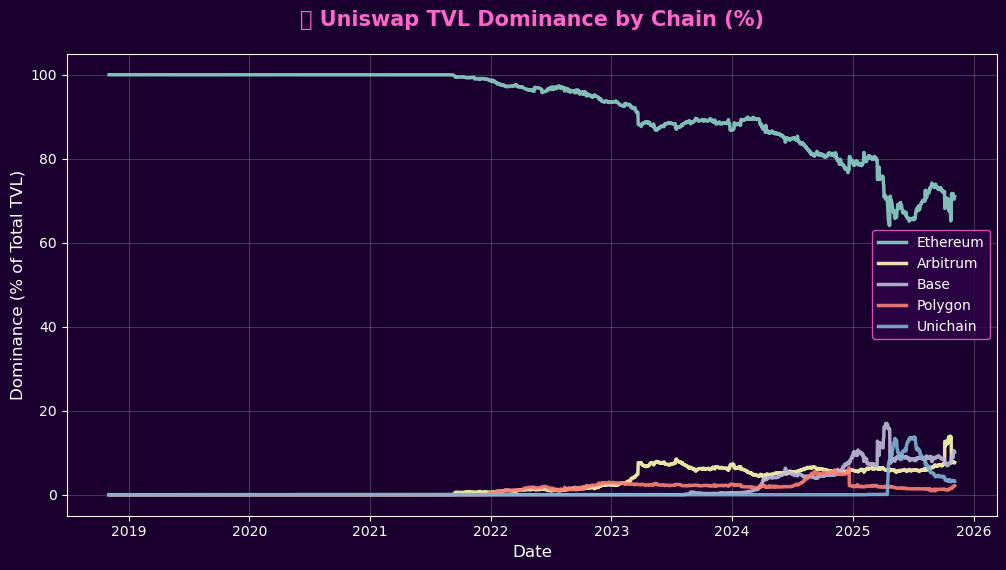

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Apply Uniswap theme (purple-pink gradient)
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,6))

# Gradient-like background using a colormap
ax.set_facecolor("#1A002E")
fig.patch.set_facecolor("#1A002E")

# Plot each chain with thicker glowing lines
for chain in top_chains:
    ax.plot(
        dominance_pivot.index,
        dominance_pivot[chain],
        linewidth=2.5,
        label=chain,
        alpha=0.9
    )

# Style text and axes
ax.set_title("💫 Uniswap TVL Dominance by Chain (%)", fontsize=15, weight="bold", color="#FF66CC", pad=20)
ax.set_xlabel("Date", fontsize=12, color="white")
ax.set_ylabel("Dominance (% of Total TVL)", fontsize=12, color="white")

# Tweak grid + legend
ax.grid(alpha=0.2, color="white")
ax.legend(facecolor="#2E0249", edgecolor="#FF66CC", fontsize=10)

# Export with transparent background for Power BI
plt.savefig("Uniswap_TVL_Dominance_UniswapTheme.png", dpi=400, bbox_inches="tight", transparent=True)
plt.show()


In [4]:
plt.savefig("Uniswap_TVL_Dominance_UniswapTheme.png", dpi=400, bbox_inches="tight", transparent=True)

<Figure size 640x480 with 0 Axes>